In [3]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
from datetime import datetime
from typing import List, Union, Iterator
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.models import Sequential
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import History, TensorBoard
from keras import Model
from keras.optimizers import Adam

## Reading data

In [35]:
data_path = '/Users/rahuln/PycharmProjects/PiCarNet/machine-learning-in-science-ii-2023'

In [36]:
def load_data(data_path: str) -> pd.DataFrame:
    """Loads data from csv file
    Params
    ------
    data_path: str
        Data path containing images and csv data
    Returns
    -------
    pd.DataFrame
        Loaded data as pandas dataframe
    """
    columns = ['image_id', 'angle', 'speed']
    data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

    return data

In [37]:
data = load_data(data_path)

In [7]:
data.head(5)

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [8]:
data['image_id'] = data.image_id.apply(lambda x: os.path.join(data_path, 'training_data/', str(x)) + '.png')

In [10]:
data.head()

,image_id,angle,speed
0,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.4375,0.0
1,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.8125,1.0
2,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.4375,1.0
3,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.6250,1.0
4,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.5000,0.0


## Data preprocessing

In [14]:
# train test split of dataset
def data_split(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Params
    ------
    data: pd.DataFrame
        Pandas dataframe containing all data.
    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of train, test and val split
    """
    rnd = np.random.RandomState(seed=None)

    #train_data = data.sample(frac=0.7, random_state=rnd)
    #test_data = data.loc[~data.index.isin(train_data.index)]
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=rnd.seed(1234)) # split data with test size of 20%
    train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=rnd.seed(1234)) # split data with overall test size of 10%

    return train_data, test_data, val_data

train_data, test_data, val_data = data_split(data)

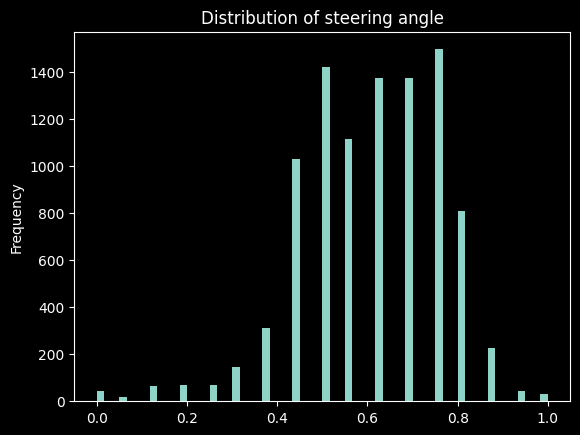

In [15]:
# plotting distribution of output labels
def visualize(data, attr):
    nBins = 60
    plt.hist(data.loc[:,attr], bins=nBins)
    plt.gca().set(title=f'Distribution of steering {attr}', ylabel='Frequency')

visualize(train_data, attr='angle')

## Data pipeline

In [17]:
# Generate images on the fly while training model
def img_generator(train_data: pd.DataFrame, test_data: pd.DataFrame, val_data: pd.DataFrame, BATCH_SIZE: int = 1024) -> Tuple[Iterator, Iterator, Iterator]:
    """
    Params
    ------
    train_data: pd.DataFrame
        Pandas dataframe containing training data
    test_data: pd.DataFrame
        Pandas dataframe containing testing data
    val_data: pd.DataFrame
        Pandas dataframe containing validation data
    use_augmentation: bool
        If true use image augmentations

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, testing and validating model.
    """

    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2)

    val_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_generator.flow_from_dataframe(dataframe=train_data,
                                                          directory=None,
                                                          x_col='image_id',
                                                          y_col='angle',
                                                          color_mode='rgb',
                                                          target_size=(224, 224),
                                                          class_mode='raw',
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)

    test_generator = test_generator.flow_from_dataframe(dataframe=test_data,
                                                x_col='image_id',
                                                y_col='angle',
                                                class_mode='raw',
                                                color_mode='rgb',
                                                target_size=(224, 224),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True)

    val_generator = val_generator.flow_from_dataframe(dataframe=val_data,
                                               x_col='image_id',
                                               y_col='angle',
                                               class_mode='raw',
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)



    return train_generator, test_generator, val_generator


In [18]:
# create base model using transfer learning
def create_baseline_model(input_shape, dropout_rate, optimizer) -> Sequential:
    """Creates a baseline model from MobileNetV2

    Params
    ------
    input_shape: input dimensions of image (224x224x3).
    dropout_rate: Applies Dropout to the input, to prevent over-fitting.
    optimizer: Optimization algorithm.

    Returns
    -------
    Sequential
        The keras model.
    """
    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    mobilenet.trainable = False # Freeze the model

    # Rebuild top
    model = Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    return model

# NOTE: we might need more complex model suggested by NVIDIA
# ref: https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2

In [19]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

lr = 1e-3 # learning rate
dropout_rate = 0.5
optimizer = Adam(learning_rate=lr)  # optimizer

baseline_model = create_baseline_model(input_shape, dropout_rate, optimizer)

Metal device set to: Apple M1 Pro


2023-03-08 21:02:24.516962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 21:02:24.516993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
#training_ds, testing_ds, validation_ds = create_img_pipeline(train_ds, test_ds, val_ds)
train_generator, test_generator, val_generator = img_generator(train_data, test_data, val_data, BATCH_SIZE=32)

Found 9654 validated image filenames.
Found 2759 validated image filenames.
Found 1380 validated image filenames.


In [25]:
# defining callbacks
def get_callbacks(model: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple keras callbacks

    Params
    ------
    model: str
        The name of model as a string

    Returns
    -------
    A list of multiple keras callbacks
    """
    logdir = (
        'logs/scalars' + model + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # logging for each model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    early_stopping_callback = EarlyStopping(
        monitor="mse",
        min_delta=1,  # model should improve by at least 1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        "./data/models/" + model + ".h5",
        monitor="mse",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    return [model_checkpoint_callback, tensorboard_callback, early_stopping_callback]

In [26]:
tf.keras.backend.clear_session() # clear keras session

In [27]:
with tf.GradientTape() as tape:
    tape.reset() # This resets gradient tape

## Training model

In [28]:
callbacks = get_callbacks('baseline_model')
baseline_model.fit(train_generator,
                   epochs=100,
                   validation_data=val_generator,
                   callbacks=callbacks,
                   workers=4,
                   verbose=1)

Epoch 1/100


2023-03-08 21:05:20.494250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


302/302 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0213

2023-03-08 21:05:50.093573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


302/302 [==============================] - 33s 105ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 2/100
302/302 [==============================] - 31s 102ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 3/100
302/302 [==============================] - 32s 105ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 4/100
302/302 [==============================] - 32s 104ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 5/100
302/302 [==============================] - 31s 103ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 6/100
302/302 [==============================] - 31s 102ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 7/100
302/302 [==============================] - 31s 103ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 8/100
302/302 [==============================] - 31s 1

In [42]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
